# Text Classification and Topic Modeling on E-commerce text dataset

### Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
#for preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from time import time
import ast
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import time

In [ ]:
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#models
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#Topic Modeling
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import models
import gensim.downloader as api
#pyLDAvis.enable_notebook()
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from IPython.display import Image, display
from gensim.parsing.preprocessing import remove_stopwords
from bertopic import BERTopic

### Preprocessing

In [ ]:
df = pd.read_csv("ecommerce.csv" )

In [ ]:
df.drop('Unnamed: 0', inplace= True, axis=1)

In [ ]:
df.head()

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [ ]:
df.label.unique()

array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

In [ ]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [ ]:
#df.dropna(inplace=True)
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)

In [ ]:
df.shape

(26803, 2)

In [ ]:
df['label'].value_counts()

Household                 9565
Books                     6256
Clothing & Accessories    5674
Electronics               5308
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

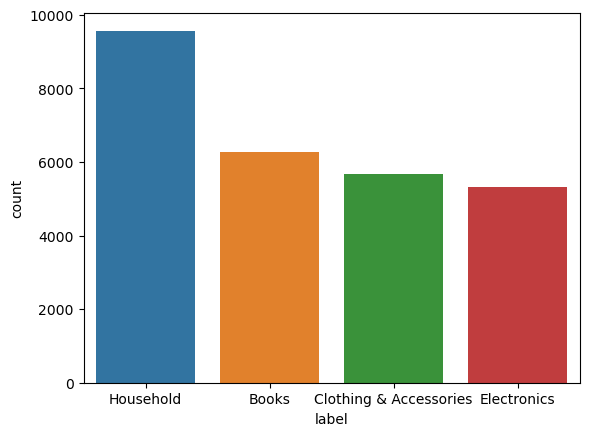

In [ ]:
sns.countplot(df['label'] )

In [ ]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

%matplotlib inline


for category in df['label'].unique():
    print(category)
    text = df[df['label'] == category]['text'].values
    wordcloud = WordCloud(background_color="white").generate(str(text))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
#pattern for URLs
re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
#pattern for email
re_email = re.compile(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+')
#for repetitions (more than 2 consecutive characters)
re_repetition = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

def cleaning(text):


    #Transform to lower-case
    text = text.lower()
    #Remove urls
    text = re.sub(re_url, ' ', text)
    #Remove email addresses
    text = re.sub(re_email, ' ', text)
    #Remove square brackets
    text = re.sub('\[.*?\]', '', text)
    #Remove \n and \r
    text = text.replace('\\n', ' ').replace('\\r', ' ')
    #Remove digit
    text = re.sub(r'(\d+)', ' ', text)
    #Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    #Remove emojis
    text= remove_emoji(text)
    #Remove non ascii char
    text = re.sub(r'[^\x00-\x7f]',r' ', text)
    #Limiting all the  repetitions to two characters.
    text = re_repetition.sub(r"\1\1", text)
    #Remove single characters
    text= re.sub(r"\b[a-zA-Z]\b", '', text)
    #Remove newline, return, tab, form [ \n\r\t\f]
    text = re.sub(r'(\s+)', ' ', text)
    #Strip whitespaces at the beginning and at the end of text
    text = text.strip()


    return text

In [ ]:
df['text_cleaned'] = df['text'].apply(cleaning)

In [ ]:
df.head()

,label,text,text_cleaned
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...


In [ ]:
#df.to_csv("cleaned.csv")

In [ ]:
example= 1006
print("Pre cleaning:\n")
print(df['text'][example])
print("===================================================================================================================")
print("Post cleaning:\n")
print(df['text_cleaned'][example])

Pre cleaning:

OYO BABY - Water Proof and Reusable Mat/Mattress Protector/Absorbent Sheets (100cm X 70cm, Medium) - Sea Blue Size:Medium                                                                                 |                            Color:Sea Blue   Peace of Mind: OYO BABY waterproof undermats will provide excellent protection against fluids, urine, perspiration, allergens, dust mites, and bacteria. It is 100% waterproof, yet breathable, comfortable and noiseless. The mat is vinyl (PVC) free and safe to sensitive skins. Silky Smooth and Soft to the Touch: OYO BABY mattress undermat is covered by high quality cotton fiber and high absorbent bamboo fiber liner, which allow the mat to feel exceptionally smooth on the skin, even after repeated uses and washes. Breathable and noiseless Barrier: Unlike traditional waterproof mats that use vinyl (PVC) as barrier, OYO BABY undermats use a safer material called TPU. TPU is toxic free, noise free and totally breathable. TPU also pre

#### Tokenization

In [ ]:
def tokenize(text):
    tokens = re.split('\W+',text)
    return tokens

df['token'] = df['text_cleaned'].apply(tokenize)
df.head()

,label,text,text_cleaned,token
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,"[paper, plane, design, framed, wall, hanging, ..."
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,"[saf, floral, framed, painting, wood, inch, in..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,"[saf, uv, textured, modern, art, print, framed..."
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,"[saf, flower, print, framed, painting, synthet..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,"[incredible, gifts, india, wooden, happy, birt..."


#### Stop Words removal

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(["on"", about", "above", "across", "after", "against", "as", "as if", "at",
                   "among", "around", "at", "before", "behind", "below", "beside", "between", "by"])

def remove_stopwords(text):
    tokenized_text_without_stopwords = []
    for token in text:
        if token not in stop_words:
            tokenized_text_without_stopwords.append(token)
    return tokenized_text_without_stopwords

df['token'] = df['token'].apply(remove_stopwords)

#### Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paola\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\paola\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#defining the object for lemmatization
wn_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wn_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df['lemma'] = df['token'].apply(lemmatizer)

In [ ]:
print("Pre lemmatization:\n")
print(df['token'][example])
print("===================================================================================================================")
print("Post lemmatization:\n")
print(df['lemma'][example])

Pre lemmatization:

['oyo', 'baby', 'water', 'proof', 'reusable', 'mat', 'mattress', 'protector', 'absorbent', 'sheets', 'cm', 'cm', 'medium', 'sea', 'blue', 'size', 'medium', 'color', 'sea', 'blue', 'peace', 'mind', 'oyo', 'baby', 'waterproof', 'undermats', 'provide', 'excellent', 'protection', 'fluids', 'urine', 'perspiration', 'allergens', 'dust', 'mites', 'bacteria', 'waterproof', 'yet', 'breathable', 'comfortable', 'noiseless', 'mat', 'vinyl', 'pvc', 'free', 'safe', 'sensitive', 'skins', 'silky', 'smooth', 'soft', 'touch', 'oyo', 'baby', 'mattress', 'undermat', 'covered', 'high', 'quality', 'cotton', 'fiber', 'high', 'absorbent', 'bamboo', 'fiber', 'liner', 'allow', 'mat', 'feel', 'exceptionally', 'smooth', 'skin', 'even', 'repeated', 'uses', 'washes', 'breathable', 'noiseless', 'barrier', 'unlike', 'traditional', 'waterproof', 'mats', 'use', 'vinyl', 'pvc', 'barrier', 'oyo', 'baby', 'undermats', 'use', 'safer', 'material', 'called', 'tpu', 'tpu', 'toxic', 'free', 'noise', 'free',

#### Stemming

In [ ]:
#defining the object for stemming
porter_stemmer = PorterStemmer()

#defining the function
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

df['stem'] = df['token'].apply(stemming)

In [ ]:
print("Pre stemming:\n")
print(df['token'][example])
print("===================================================================================================================")
print("Post stemming:\n")
print(df['stem'][example])

Pre stemming:

['oyo', 'baby', 'water', 'proof', 'reusable', 'mat', 'mattress', 'protector', 'absorbent', 'sheets', 'cm', 'cm', 'medium', 'sea', 'blue', 'size', 'medium', 'color', 'sea', 'blue', 'peace', 'mind', 'oyo', 'baby', 'waterproof', 'undermats', 'provide', 'excellent', 'protection', 'fluids', 'urine', 'perspiration', 'allergens', 'dust', 'mites', 'bacteria', 'waterproof', 'yet', 'breathable', 'comfortable', 'noiseless', 'mat', 'vinyl', 'pvc', 'free', 'safe', 'sensitive', 'skins', 'silky', 'smooth', 'soft', 'touch', 'oyo', 'baby', 'mattress', 'undermat', 'covered', 'high', 'quality', 'cotton', 'fiber', 'high', 'absorbent', 'bamboo', 'fiber', 'liner', 'allow', 'mat', 'feel', 'exceptionally', 'smooth', 'skin', 'even', 'repeated', 'uses', 'washes', 'breathable', 'noiseless', 'barrier', 'unlike', 'traditional', 'waterproof', 'mats', 'use', 'vinyl', 'pvc', 'barrier', 'oyo', 'baby', 'undermats', 'use', 'safer', 'material', 'called', 'tpu', 'tpu', 'toxic', 'free', 'noise', 'free', 'tot

In [ ]:
df.head()

,label,text,text_cleaned,token,lemma,stem
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,"[paper, plane, design, framed, wall, hanging, ...","[paper, plane, design, framed, wall, hanging, ...","[paper, plane, design, frame, wall, hang, moti..."
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,"[saf, floral, framed, painting, wood, inch, in...","[saf, floral, framed, painting, wood, inch, in...","[saf, floral, frame, paint, wood, inch, inch, ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,"[saf, uv, textured, modern, art, print, framed...","[saf, uv, textured, modern, art, print, framed...","[saf, uv, textur, modern, art, print, frame, p..."
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,"[saf, flower, print, framed, painting, synthet...","[saf, flower, print, framed, painting, synthet...","[saf, flower, print, frame, paint, synthet, in..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,"[incredible, gifts, india, wooden, happy, birt...","[incredible, gift, india, wooden, happy, birth...","[incred, gift, india, wooden, happi, birthday,..."


In [ ]:
#df.to_csv("ecom_preprocessed.csv")

### Text representation

In [ ]:
df= pd.read_csv("ecom_preprocessed.csv")

In [ ]:
def trasf_list(sent):
    sent= ast.literal_eval(sent)
    return sent
df['lemma']= df['lemma'].apply(trasf_list) #convert to list because pandas import the column as a string type

#### Tokens' exploration

In [ ]:
data_views = df[['label','lemma']]
data_views['tokens'] = data_views.lemma.apply(lambda x: len(x))
data_views['chars'] = data_views.lemma.apply(lambda x: sum(len(i) for i in x))

In [ ]:
lab_household = data_views[data_views['label'] == 'Household']
lab_electronics = data_views[data_views['label'] == 'Electronics']
lab_books = data_views[data_views['label'] == 'Books']
lab_cloth_acc = data_views[data_views['label'] == 'Clothing & Accessories']

In [ ]:
figure, axes = plt.subplots(2, 2, figsize=(20,10))
figure.suptitle("Token's distribution by class",size=18)

axes[0,0].set_title('Household',size=12)
axes[0,1].set_title('Electronics',size=12)
axes[1,0].set_title('Books',size=12)
axes[1,1].set_title('Clothing & Accessories',size=12)

sns.set_style('white')
sns.histplot(ax=axes[0,0], data=lab_household[lab_household['tokens'] < 360], x = 'tokens',bins=36)
sns.histplot(ax=axes[0,1], data=lab_electronics[lab_electronics['tokens'] < 360], x = 'tokens',bins=36)
sns.histplot(ax=axes[1,0], data=lab_books[lab_books['tokens'] < 360], x = 'tokens',bins=36)
sns.histplot(ax=axes[1,1], data=lab_cloth_acc[lab_cloth_acc['tokens'] < 360], x = 'tokens',bins=36)
sns.despine()
plt.show()

#### Split train test set

In [ ]:
X= df["lemma"]
Y= df["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,stratify=Y, shuffle=True, random_state=42)

In [ ]:
print(f"Num obs. train set:\t{X_train.shape[0]}")
print(f"Num obs. test set:\t{X_test.shape[0]}")

Num obs. train set:	18762
Num obs. test set:	8041


#### Count vectorizer

In [ ]:
cv_vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x )#, max_features = 4000)
X_tr_cv = cv_vectorizer.fit_transform(X_train)
X_test_cv= cv_vectorizer.transform(X_test)

In [ ]:
Doc_Term_Matrix = pd.DataFrame(X_tr_cv.toarray(),columns= cv_vectorizer.get_feature_names())

In [ ]:
Doc_Term_Matrix.iloc[:10, 6480:6500] #print a chunck of this sparse matrix

,carotenoid,carousel,carpal,carpathian,carpathians,carpentary,carpenter,carpentry,carpet,carpetbagger,carpeted,carprie,carr,carranza,carrel,carreyrou,carriage,carrie,carried,carrier
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Vectorizer with bi-grams

In [ ]:
bi_vectorizer = CountVectorizer(ngram_range = (1,2),tokenizer=lambda x: x, preprocessor=lambda x: x, max_features = 2000)
X_tr_bi = bi_vectorizer.fit_transform(X_train)
X_test_bi= bi_vectorizer.transform(X_test)

#### Vectorizer with tf-idf

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x, preprocessor=lambda x: x )#, max_features = 4000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Text Classification

#### utility function

In [ ]:
def prettify_confusion_matrix(y_true, y_pred):
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='Blues',
                yticklabels=sorted(y_test.unique()))
    plt.show()

#### Features selection

In [ ]:
chi2_selector = SelectKBest(chi2, k=3000)

In [ ]:
chi2_selector.fit(X_tr_cv, y_train)

SelectKBest(k=3000, score_func=<function chi2 at 0x000001C9C7D90310>)

In [ ]:
X_train_cv_best= chi2_selector.transform(X_tr_cv).toarray()
X_test_cv_best= chi2_selector.transform(X_test_cv).toarray()

In [ ]:
chi2_selector.fit(X_train_tfidf, y_train)

SelectKBest(k=3000, score_func=<function chi2 at 0x000001C9C7D90310>)

In [ ]:
X_train_tfidf_best= chi2_selector.transform(X_train_tfidf).toarray()
X_test_tfidf_best= chi2_selector.transform(X_test_tfidf).toarray()

In [ ]:
chi2_selector = SelectKBest(chi2, k=2000) # 2000 for computational reason
chi2_selector.fit(X_tr_bi, y_train)

SelectKBest(k=2000, score_func=<function chi2 at 0x000001C9C7D90310>)

In [ ]:
X_train_bi_best= chi2_selector.transform(X_tr_bi).toarray()
X_test_bi_best= chi2_selector.transform(X_test_bi).toarray()

### Models

##### Multinomial Naive Bayes

In [ ]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
          'fit_prior': [True, False],
         }

nb = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
nb.fit(X_train_cv_best,y_train)

print('Best Parameters : {}'.format(nb.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(nb.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters : {'alpha': 0.01, 'fit_prior': False}
Best Accuracy Through Grid Search : 0.935



CountVect predictions

                        precision    recall  f1-score   support

                 Books       0.96      0.90      0.93      1877
Clothing & Accessories       0.94      0.98      0.96      1702
           Electronics       0.90      0.93      0.92      1592
             Household       0.93      0.93      0.93      2870

              accuracy                           0.93      8041
             macro avg       0.93      0.93      0.93      8041
          weighted avg       0.93      0.93      0.93      8041



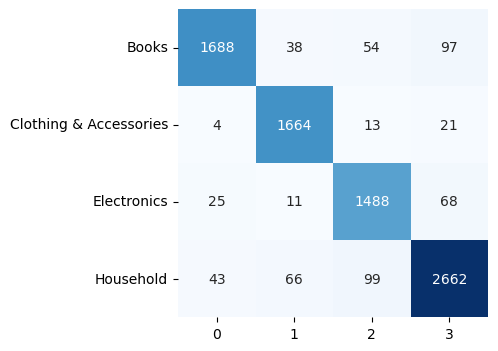

In [ ]:
y_pred_nb = nb.predict(X_test_cv_best)
y_prob_nb = nb.predict_proba(X_test_cv_best)[:,1]
print(classification_report(y_test,y_pred_nb))
prettify_confusion_matrix(y_test, y_pred_nb)

Bigrams predictions

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters : {'alpha': 0.01, 'fit_prior': False}
Best Accuracy Through Grid Search : 0.926

                        precision    recall  f1-score   support

                 Books       0.96      0.89      0.92      1877
Clothing & Accessories       0.91      0.97      0.94      1702
           Electronics       0.89      0.92      0.91      1592
             Household       0.92      0.91      0.92      2870

              accuracy                           0.92      8041
             macro avg       0.92      0.92      0.92      8041
          weighted avg       0.92      0.92      0.92      8041



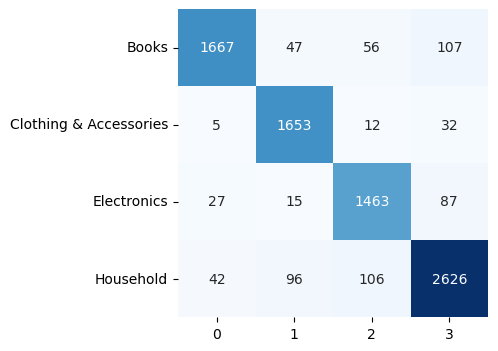

In [ ]:
nb = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
nb.fit(X_train_bi_best,y_train)
print('Best Parameters : {}'.format(nb.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(nb.best_score_))
y_pred_nb_bi = nb.predict(X_test_bi_best)
y_prob_nb_bi = nb.predict_proba(X_test_bi_best)[:,1]
print(classification_report(y_test,y_pred_nb_bi))
prettify_confusion_matrix(y_test, y_pred_nb_bi)

Tf-idf predictions

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters : {'alpha': 0.01, 'fit_prior': False}
Best Accuracy Through Grid Search : 0.942

                        precision    recall  f1-score   support

                 Books       0.96      0.90      0.93      1877
Clothing & Accessories       0.94      0.97      0.96      1702
           Electronics       0.90      0.94      0.92      1592
             Household       0.94      0.93      0.93      2870

              accuracy                           0.94      8041
             macro avg       0.93      0.94      0.94      8041
          weighted avg       0.94      0.94      0.94      8041



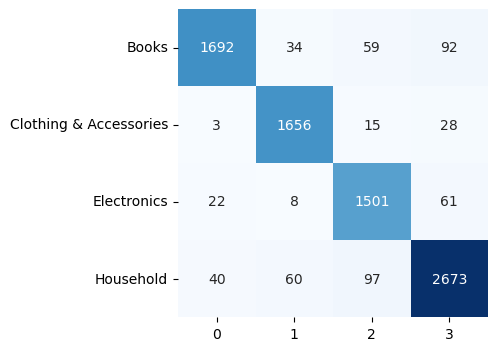

In [ ]:
nb = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
nb.fit(X_train_tfidf_best,y_train)
print('Best Parameters : {}'.format(nb.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(nb.best_score_))
y_pred_nb_tf = nb.predict(X_test_tfidf_best)
y_prob_nb_tf = nb.predict_proba(X_test_tfidf_best)[:,1]
print(classification_report(y_test,y_pred_nb_tf))
prettify_confusion_matrix(y_test, y_pred_nb_tf)

##### Logistic Regression

In [ ]:
params = {'C': [0.1, 1, 10],
          'penalty': ['l2'],
          'solver': ['lbfgs','newton-cg'],
          'multi_class': ['multinomial']
         }

lr = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, n_jobs=-1, cv=5, verbose=5)
lr.fit(X_train_cv_best,y_train)

print('Best Parameters : {}'.format(lr.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(lr.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters : {'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy Through Grid Search : 0.934



Cv pred

                        precision    recall  f1-score   support

                 Books       0.90      0.93      0.92      1877
Clothing & Accessories       0.96      0.96      0.96      1702
           Electronics       0.93      0.90      0.92      1592
             Household       0.93      0.93      0.93      2870

              accuracy                           0.93      8041
             macro avg       0.93      0.93      0.93      8041
          weighted avg       0.93      0.93      0.93      8041



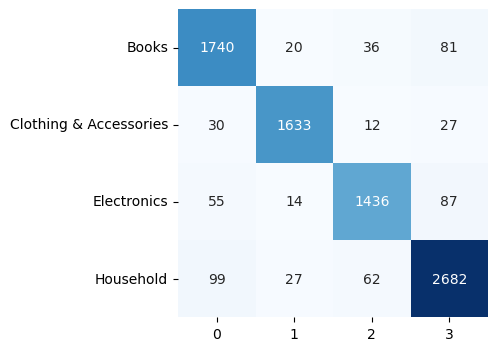

In [ ]:
y_pred_lr = lr.predict(X_test_cv_best)
y_prob_lr = lr.predict_proba(X_test_cv_best)[:,1]
print(classification_report(y_test,y_pred_lr))
prettify_confusion_matrix(y_test, y_pred_lr)

Bigrams predictions

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters : {'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy Through Grid Search : 0.926

                        precision    recall  f1-score   support

                 Books       0.89      0.93      0.91      1877
Clothing & Accessories       0.96      0.95      0.96      1702
           Electronics       0.92      0.89      0.91      1592
             Household       0.93      0.93      0.93      2870

              accuracy                           0.93      8041
             macro avg       0.93      0.92      0.92      8041
          weighted avg       0.93      0.93      0.93      8041



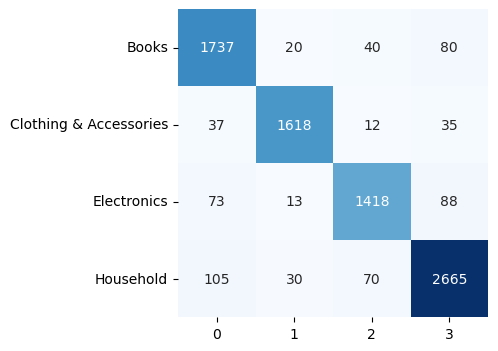

In [ ]:
lr.fit(X_train_bi_best,y_train)
print('Best Parameters : {}'.format(lr.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(lr.best_score_))
y_pred_lr_bi = lr.predict(X_test_bi_best)
y_prob_lr_bi = lr.predict_proba(X_test_bi_best)[:,1]
print(classification_report(y_test,y_pred_lr_bi))
prettify_confusion_matrix(y_test, y_pred_lr_bi)

tf-idf predictions

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters : {'C': 10, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy Through Grid Search : 0.947

                        precision    recall  f1-score   support

                 Books       0.94      0.93      0.93      1877
Clothing & Accessories       0.97      0.97      0.97      1702
           Electronics       0.95      0.93      0.94      1592
             Household       0.94      0.96      0.95      2870

              accuracy                           0.95      8041
             macro avg       0.95      0.95      0.95      8041
          weighted avg       0.95      0.95      0.95      8041



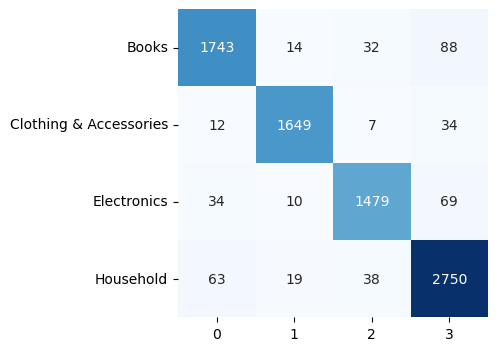

In [ ]:
lr.fit(X_train_tfidf_best,y_train)
print('Best Parameters : {}'.format(lr.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(lr.best_score_))
y_pred_lr_tf = lr.predict(X_test_tfidf_best)
y_prob_lr_tf = lr.predict_proba(X_test_tfidf_best)[:,1]
print(classification_report(y_test,y_pred_lr_tf))
prettify_confusion_matrix(y_test, y_pred_lr_tf)

In [ ]:
rf= RandomForestClassifier(random_state=42,max_features='log2')

Countvect predictions

In [ ]:
rf.fit(X_train_cv_best,y_train)

RandomForestClassifier(max_features='log2', random_state=42)

                        precision    recall  f1-score   support

                 Books       0.94      0.91      0.93      1877
Clothing & Accessories       0.96      0.97      0.96      1702
           Electronics       0.95      0.88      0.91      1592
             Household       0.90      0.95      0.93      2870

              accuracy                           0.93      8041
             macro avg       0.94      0.93      0.93      8041
          weighted avg       0.93      0.93      0.93      8041



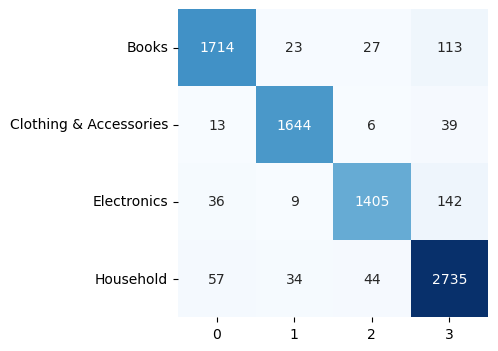

In [ ]:
y_pred_rf = rf.predict(X_test_cv_best)
y_prob_rf = rf.predict_proba(X_test_cv_best)[:,1]
print(classification_report(y_test,y_pred_rf))
prettify_confusion_matrix(y_test, y_pred_rf)

Bigrams predictions

                        precision    recall  f1-score   support

                 Books       0.94      0.91      0.93      1877
Clothing & Accessories       0.95      0.96      0.96      1702
           Electronics       0.94      0.88      0.91      1592
             Household       0.90      0.95      0.92      2870

              accuracy                           0.93      8041
             macro avg       0.93      0.93      0.93      8041
          weighted avg       0.93      0.93      0.93      8041



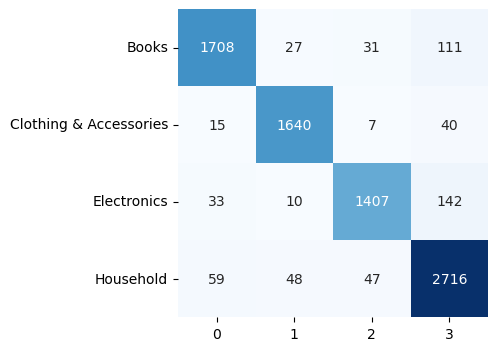

In [ ]:
rf.fit(X_train_bi_best,y_train)
#print('Best Parameters : {}'.format(rf.best_params_))
#print('Best Accuracy Through Grid Search : {:.3f}\n'.format(rf.best_score_))
y_pred_rf_bi = rf.predict(X_test_bi_best)
y_prob_rf_bi = rf.predict_proba(X_test_bi_best)[:,1]
print(classification_report(y_test,y_pred_rf_bi))
prettify_confusion_matrix(y_test, y_pred_rf_bi)

Tf-idf predictions

                        precision    recall  f1-score   support

                 Books       0.95      0.91      0.93      1877
Clothing & Accessories       0.96      0.97      0.96      1702
           Electronics       0.95      0.89      0.92      1592
             Household       0.90      0.96      0.93      2870

              accuracy                           0.94      8041
             macro avg       0.94      0.93      0.94      8041
          weighted avg       0.94      0.94      0.94      8041



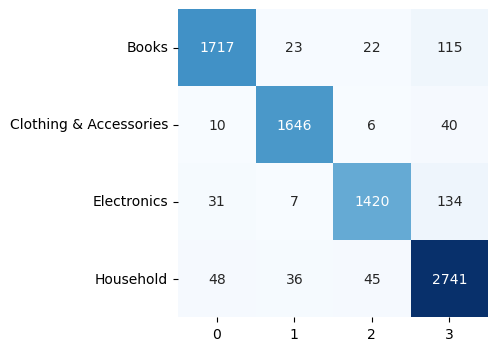

In [ ]:
rf.fit(X_train_tfidf_best,y_train)
#print('Best Parameters : {}'.format(nb.best_params_))
#print('Best Accuracy Through Grid Search : {:.3f}\n'.format(nb.best_score_))
y_pred_rf_tf = rf.predict(X_test_tfidf_best)
y_prob_rf_tf = rf.predict_proba(X_test_tfidf_best)[:,1]
print(classification_report(y_test,y_pred_rf_tf))
prettify_confusion_matrix(y_test, y_pred_rf_tf)

#### Recap on performance

Please note that since it is a multiclass classification the measures of precision, recall and f1 refer to the macro average value

| Model | Representation | Accuracy | Precision | Recall | f1-score |
| --- | ---- | --- | --- | --- | --- |
| Multinomial Naive Bayes | CountVect | 0.93 | 0.93 | 0.93 | 0.93 |
| Multinomial Naive Bayes | Bigrams | 0.92 | 0.92 | 0.92 | 0.92 |
| Multinomial Naive Bayes | Tf-Idf | 0.94 | 0.93 | 0.94 | 0.94 |
| LogisticRegression | CountVect |0.93 | 0.93 | 0.93 | 0.93 |
| LogisticRegression | Bigrams |0.93 | 0.93 | 0.92 | 0.92 |
| LogisticRegression | Tf-Idf |0.95 | 0.95 | 0.95 | 0.95 |
| Random Forest| CountVect | 0.93 | 0.94 | 0.93 | 0.93 |
| Random Forest| Bigrams | 0.93 | 0.93 | 0.93 | 0.93 |
| Random Forest| Tf_Idf | 0.94 | 0.94 | 0.93 | 0.94 |

#### Models comparison

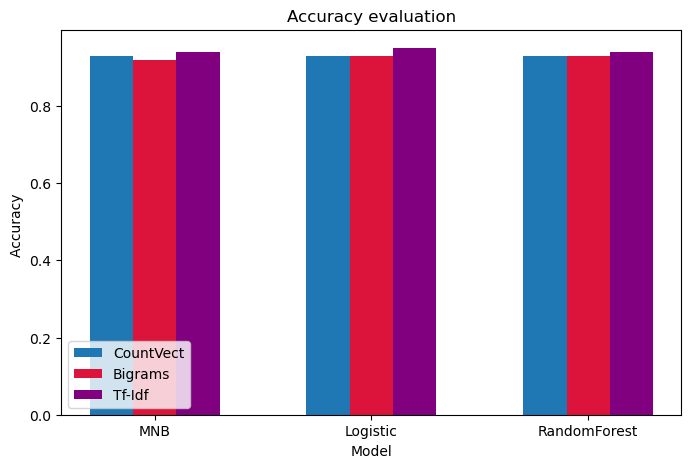

In [ ]:
plt.figure(figsize=(8,5))

X = ['MNB','Logistic','RandomForest']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, [0.93, 0.93, 0.93], 0.2, label = 'CountVect')
plt.bar(X_axis + 0.0, [0.92, 0.93, 0.93 ], 0.2, label = 'Bigrams', color='crimson')
plt.bar(X_axis + 0.2, [0.94, 0.95, 0.94 ], 0.2, label = 'Tf-Idf', color='purple')

plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Accuracy ")
plt.title("Accuracy evaluation")
plt.legend(loc=3)
plt.show()

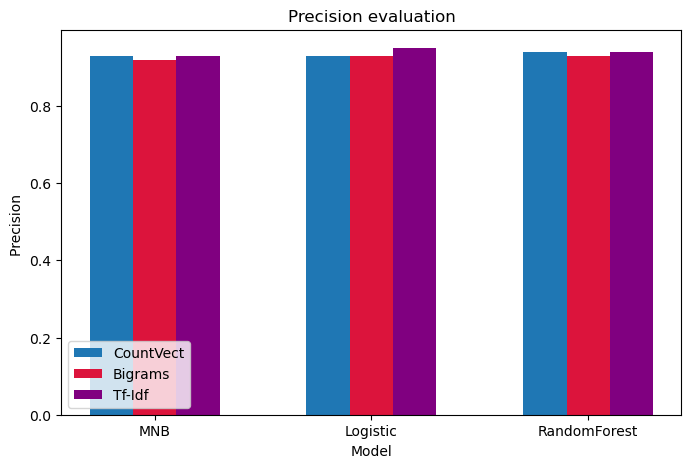

In [ ]:
plt.figure(figsize=(8,5))

X = ['MNB','Logistic','RandomForest']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, [0.93, 0.93, 0.94], 0.2, label = 'CountVect')
plt.bar(X_axis + 0.0, [0.92, 0.93, 0.93 ], 0.2, label = 'Bigrams', color='crimson')
plt.bar(X_axis + 0.2, [0.93, 0.95, 0.94 ], 0.2, label = 'Tf-Idf', color='purple')

plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Precision ")
plt.title("Precision evaluation")
plt.legend(loc=3)
plt.show()

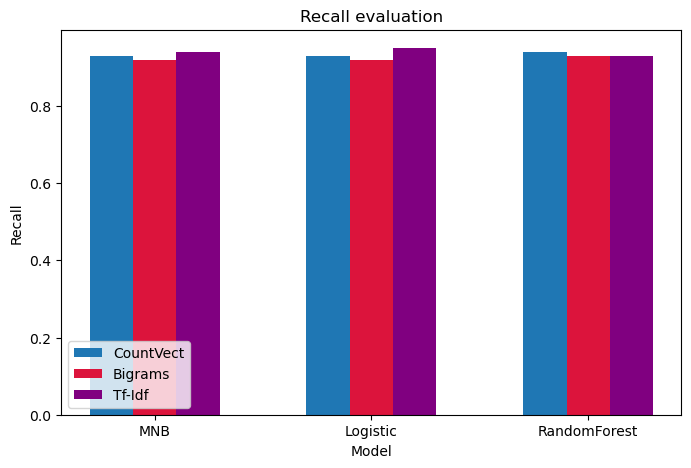

In [ ]:
plt.figure(figsize=(8,5))

X = ['MNB','Logistic','RandomForest']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, [0.93, 0.93, 0.94], 0.2, label = 'CountVect')
plt.bar(X_axis + 0.0, [0.92, 0.92, 0.93 ], 0.2, label = 'Bigrams', color='crimson')
plt.bar(X_axis + 0.2, [0.94, 0.95, 0.93 ], 0.2, label = 'Tf-Idf', color='purple')

plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Recall")
plt.title("Recall evaluation")
plt.legend(loc=3)
plt.show()

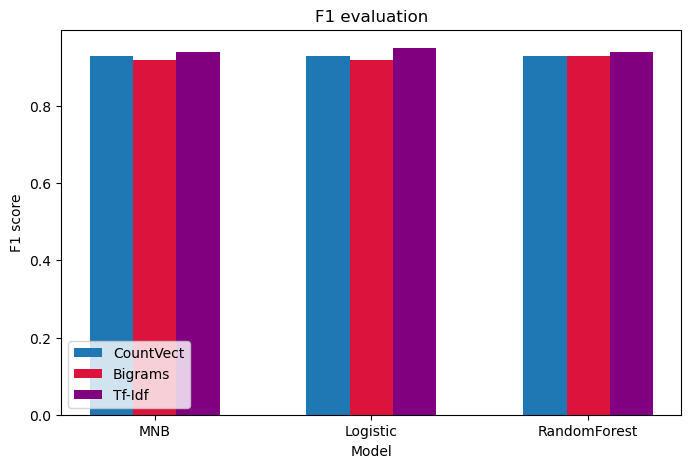

In [ ]:
plt.figure(figsize=(8,5))

X = ['MNB','Logistic','RandomForest']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, [0.93, 0.93, 0.93], 0.2, label = 'CountVect')
plt.bar(X_axis + 0.0, [0.92, 0.92, 0.93 ], 0.2, label = 'Bigrams', color='crimson')
plt.bar(X_axis + 0.2, [0.94, 0.95, 0.94 ], 0.2, label = 'Tf-Idf', color='purple')

plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("F1 score")
plt.title("F1 evaluation")
plt.legend(loc=3)
plt.show()

### Topic Modeling

In [ ]:
texts= list(df.lemma)

In [ ]:
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.8) #Filter out tokens that appear in less than 5 documents, more than 80% of corpus


In [ ]:
id2word = corpora.Dictionary(texts)

In [ ]:
id2word[20] #print word example from dictionary

'elegance'

In [ ]:
len(dictionary)

16624

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts] #Convert document into the bag-of-words form

In [ ]:
doc_id = 8
print(texts[doc_id][:10])
print(corpus[doc_id][:10])


['painting', 'villa', 'uv', 'textured', 'modern', 'art', 'print', 'framed', 'painting', 'home']
[(3, 3), (13, 3), (24, 1), (26, 1), (27, 4), (36, 3), (52, 2), (58, 1), (59, 4), (66, 3)]


In [ ]:
print(texts[:3])
print(corpus[:3])

[['paper', 'plane', 'design', 'framed', 'wall', 'hanging', 'motivational', 'office', 'decor', 'art', 'print', 'inch', 'set', 'painting', 'made', 'synthetic', 'frame', 'uv', 'textured', 'print', 'give', 'multi', 'effect', 'attracts', 'towards', 'special', 'series', 'painting', 'make', 'wall', 'beautiful', 'give', 'royal', 'touch', 'painting', 'ready', 'hang', 'would', 'proud', 'posse', 'unique', 'painting', 'niche', 'apart', 'use', 'modern', 'efficient', 'printing', 'technology', 'print', 'ink', 'precision', 'epson', 'roland', 'hp', 'printer', 'innovative', 'hd', 'printing', 'technique', 'result', 'durable', 'spectacular', 'looking', 'print', 'highest', 'last', 'lifetime', 'print', 'solely', 'top', 'notch', 'ink', 'achieve', 'brilliant', 'true', 'colour', 'due', 'high', 'level', 'uv', 'resistance', 'print', 'retain', 'beautiful', 'colour', 'many', 'year', 'add', 'colour', 'style', 'living', 'space', 'digitally', 'printed', 'painting', 'pleasure', 'eternal', 'bliss', 'bring', 'home', 'el

#### Tuning hyperparameters ( alpha and number of topics)

In [ ]:
#compute coherence for different alpha and num_topics
#higher coherence better model
def evaluate_coherence(dictionary, corpus, texts, num_topics_values, alpha_values):

    coherence_values = [] #list to collect coherence values
    models = []  #list to collect models evaluated

    for alpha in alpha_values:   #iterate over different alphas

        for num_topics in num_topics_values:  #iterate over different numbers of topics

            #instantiate LDA model
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               alpha=alpha,
                                               random_state=42,
                                               chunksize=100, #chunksize:number of documents to consider at once (affects the memory consumption)
                                               passes=10,
                                               per_word_topics=True #allows for extraction of the most likely topics given a word
                                                       )
            models.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))


    return models, coherence_values


In [ ]:
num_topics_values= [4,6,8,10,12,14,16] #minimum 4, we know that from the labels
alpha_values = [0.01, 0.1, 1]

In [ ]:
start = time.time()
models, coherence_values = evaluate_coherence(dictionary=id2word, corpus=corpus, texts=texts,
                                                        num_topics_values=num_topics_values, alpha_values=alpha_values)
end = time.time()
total_time = round((end - start)/60)
print("\ncomp_time in min\t"+ str(total_time))


comp_time in min	128


In [ ]:
coherence_eval = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence'])
coherence_eval.sort_values('coherence',ascending=False)

,alpha,num_topics,coherence
12,0.10,14,0.583173
4,0.01,12,0.580721
5,0.01,14,0.570886
3,0.01,10,0.567298
11,0.10,12,0.562180
2,0.01,8,0.556304
9,0.10,8,0.540646
10,0.10,10,0.534729
6,0.01,16,0.532640
1,0.01,6,0.531896


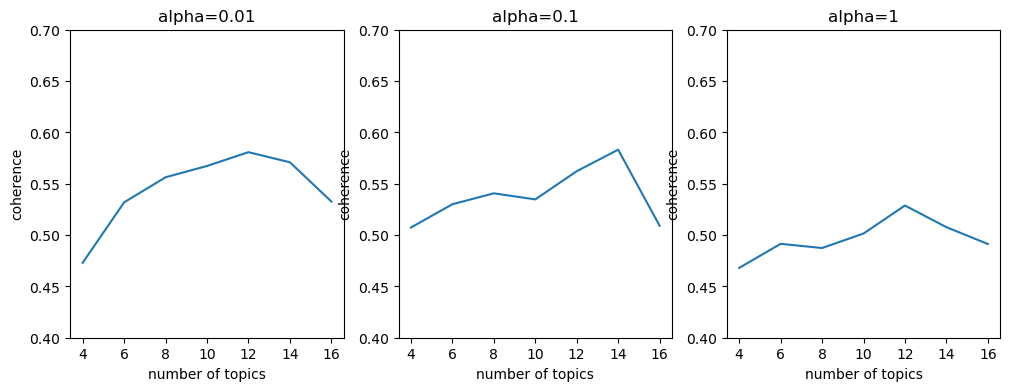

In [ ]:
def plot_co_eval(coherence_eval, alpha_values, num_topics_values):
    plt.figure(figsize=(12,4))

    for i, val in enumerate(alpha_values):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_eval[coherence_eval['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence"])
        plt.xlabel('number of topics')
        plt.ylabel('coherence')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.4, 0.7])
        plt.xticks(num_topics_values)

plot_co_eval(coherence_eval, alpha_values, num_topics_values)

In [ ]:
#build the final model with the highest coherence value
start = time.time()
LDA_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=14, random_state=42, chunksize=100,
                                            passes=10, alpha=0.1,per_word_topics=True)
end = time.time()
total_time = round((end - start)/60)
print("\ndelta_time in min:  "+ str(total_time))


delta_time in min:  8


##### Evaluation

In [ ]:
#compute coherence of the final model
coherence_model_lda = CoherenceModel(model=LDA_model, texts=texts, dictionary=id2word, coherence='c_v')
print('\nCoherence Score (c_v): ', coherence_model_lda.get_coherence())

#compute log perplexity of the final model
print('\nPerplexity: ', LDA_model.log_perplexity(corpus))


Coherence Score (c_v):  0.5831728526038275

Perplexity:  -12.03856354509212


try other scores for coherence

In [ ]:
#compute coherence of the final model
coherence_model_lda = CoherenceModel(model=LDA_model, texts=texts, dictionary=id2word, coherence='c_uci')
print('\nCoherence Score (c_uci): ', coherence_model_lda.get_coherence())



Coherence Score (c_uci):  -8.946807622104815


In [ ]:
#compute coherence of the final model
coherence_model_lda = CoherenceModel(model=LDA_model, texts=texts, dictionary=id2word, coherence='u_mass')
print('\nCoherence Score (u_mass): ', coherence_model_lda.get_coherence())



Coherence Score (u_mass):  -13.87404619939038


#### Visualization

In [ ]:
pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim_models.prepare(LDA_model, corpus, id2word)
lda_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.245499  0.002066       1        1  25.542577
7     -0.155681 -0.070842       2        1  11.655729
6      0.217586  0.045945       3        1  11.082950
9      0.162259 -0.069966       4        1   8.643277
2      0.144549  0.051712       5        1   8.533140
0      0.062400  0.073114       6        1   6.590412
13     0.160061  0.049720       7        1   6.121921
3      0.030713  0.103511       8        1   5.426669
4     -0.123704 -0.366955       9        1   5.004084
11     0.013905 -0.217600      10        1   4.541227
8     -0.198237  0.117909      11        1   1.975059
10    -0.192540  0.098079      12        1   1.943711
12    -0.185234  0.049495      13        1   1.651823
1     -0.181574  0.133812      14        1   1.287424, topic_info=                   Term          Freq         Total Category  logprob  loglift
6096           carpeted  24014.000000  24014.000000  Default  30.0000  30.0000
780               sheet  24196.000000  24196.000000  Default  29.0000  29.0000
3252           maximize  14441.000000  14441.000000  Default  28.0000  28.0000
2585             secure  10405.000000  10405.000000  Default  27.0000  27.0000
3550              equal   8577.000000   8577.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
4229               hall    130.780900    131.791319  Topic14  -5.2039   4.3448
4125  morespecification    125.061178    126.071598  Topic14  -5.2486   4.3445
639              course   1321.713873   1632.212586  Topic14  -2.8908   4.1415
290             stylish    694.238357   2176.471763  Topic14  -3.5346   3.2099
113              action    157.289378   1728.598487  Topic14  -5.0193   1.9555

[584 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11919     13  0.993518      aadinath
382        8  0.070678        absorb
382       10  0.928910        absorb
112       14  0.999336      abstract
4607       9  0.999387      accepted
...      ...       ...           ...
5133       2  0.314467  woodassembly
5133      13  0.685131  woodassembly
1741       6  0.999774         woven
6116       9  0.998972      yutiriti
4647      13  0.987922         zuari

[713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 7, 10, 3, 1, 14, 4, 5, 12, 9, 11, 13, 2])

In [ ]:
cols= ['#8ffe09', '#13eac9', '#069af3', '#ab9004', '#ca9bf7', '#fe46a5', '#990f4b', '#b5c306', '#fe4b03',
      '#464196', '#0f9b8e', '#fe828c', '#c14a09', '#ff69af']
#stop_words = stopwords.words('english')

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = LDA_model.show_topics(formatted=False, num_topics=14,num_words=30)

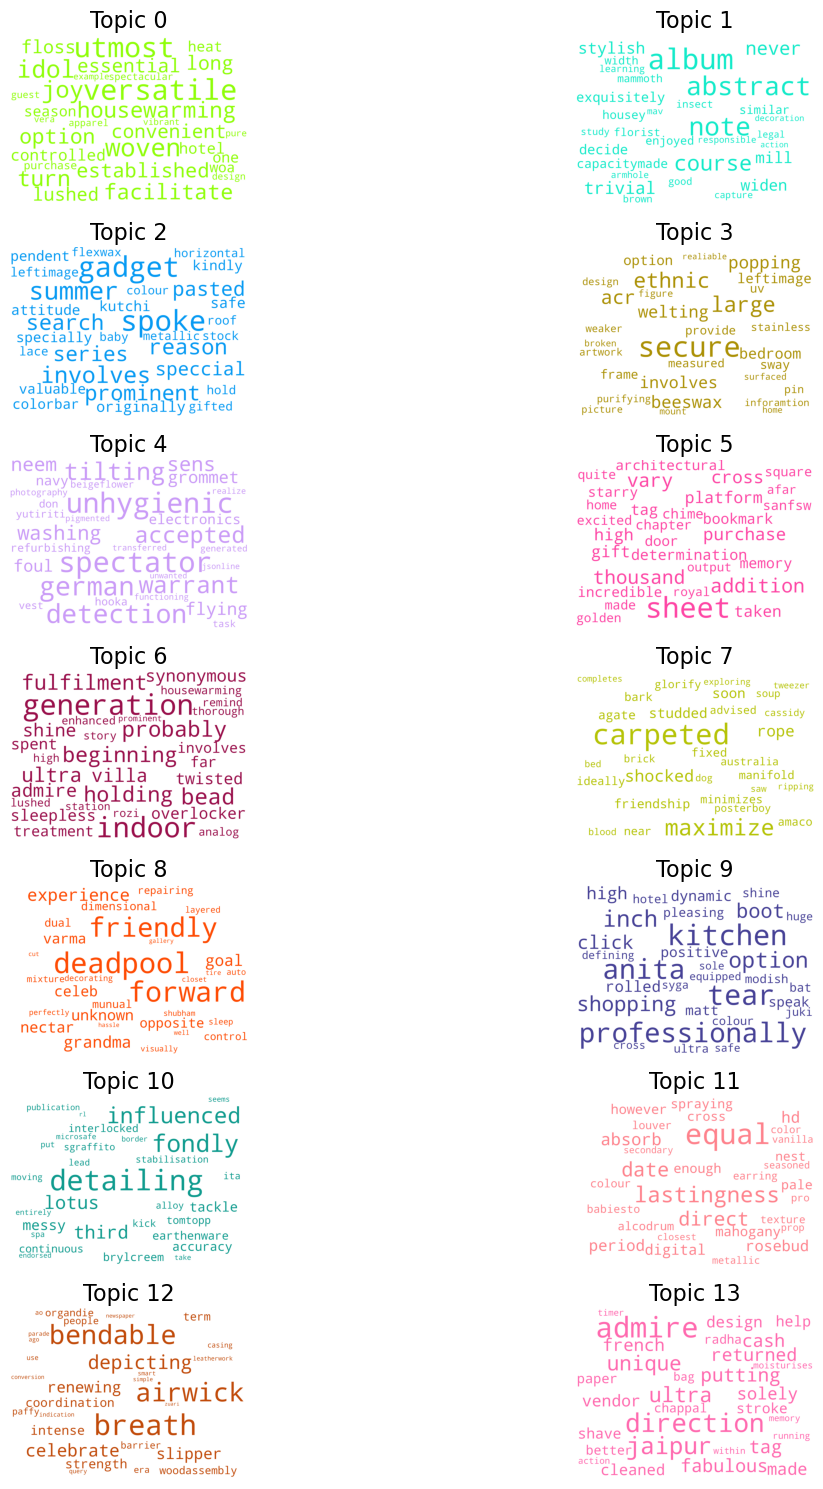

In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Further exploration...

Assign each document to its dominant topic

In [ ]:
topics_df = pd.DataFrame()

for i, row in enumerate(LDA_model[corpus]):
    row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:#dominant
            wp = LDA_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
contents = pd.Series(texts)
topics_df = pd.concat([topics_df, contents], axis=1)
topics_df = pd.concat([topics_df, df.label], axis=1)
topics_df = topics_df.reset_index()
topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'label']

In [ ]:
topics_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,label
0,0,5,0.5791,"sheet, addition, vary, thousand, cross, purcha...","[paper, plane, design, framed, wall, hanging, ...",Household
1,1,2,0.3723,"spoke, gadget, summer, involves, reason, searc...","[saf, floral, framed, painting, wood, inch, in...",Household
2,2,3,0.3719,"secure, large, ethnic, acr, popping, beeswax, ...","[saf, uv, textured, modern, art, print, framed...",Household
3,3,3,0.3457,"secure, large, ethnic, acr, popping, beeswax, ...","[saf, flower, print, framed, painting, synthet...",Household
4,4,5,0.5924,"sheet, addition, vary, thousand, cross, purcha...","[incredible, gift, india, wooden, happy, birth...",Household


Num of documents per  topic

In [ ]:
topics_df.groupby('Dominant_Topic')['Document_No'].count().reset_index(name='Doc_count').sort_values('Doc_count', ascending=False)

,Dominant_Topic,Doc_count
5,5,7945
7,7,3223
0,0,3209
6,6,2973
9,9,2291
2,2,2181
4,4,1459
3,3,1255
13,13,1017
11,11,705


Use the label information to see if there are topics more related to a specific type of product

In [ ]:
topics_df.groupby(['Dominant_Topic', 'label'])['Document_No'].count().reset_index(name='Doc_count')

,Dominant_Topic,label,Doc_count
0,0,Books,161
1,0,Clothing & Accessories,2656
2,0,Electronics,70
3,0,Household,322
4,1,Books,83
5,1,Clothing & Accessories,2
6,1,Electronics,8
7,1,Household,49
8,2,Books,216
9,2,Clothing & Accessories,567


In [ ]:
for i in range(14):
    index= topics_df[topics_df['Dominant_Topic']==i].sort_values('Topic_Perc_Contrib', ascending=False).iloc[0,0]
    print('Keywords for topic'+ str(i)+': '+topics_df.Keywords[index]+ '\n')

Keywords for topic0: versatile, utmost, woven, idol, joy, turn, housewarming, facilitate, option, established

Keywords for topic1: album, abstract, note, course, never, trivial, stylish, mill, widen, decide

Keywords for topic2: spoke, gadget, summer, involves, reason, search, prominent, series, pasted, speccial

Keywords for topic3: secure, large, ethnic, acr, popping, beeswax, welting, involves, bedroom, leftimage

Keywords for topic4: spectator, unhygienic, german, detection, tilting, warrant, accepted, sens, washing, neem

Keywords for topic5: sheet, addition, vary, thousand, cross, purchase, high, gift, platform, taken

Keywords for topic6: generation, indoor, bead, probably, beginning, holding, fulfilment, ultra, villa, admire

Keywords for topic7: carpeted, maximize, shocked, rope, studded, soon, friendship, agate, fixed, bark

Keywords for topic8: deadpool, forward, friendly, experience, grandma, goal, nectar, unknown, celeb, varma

Keywords for topic9: kitchen, tear, anita, p

Print original text (not preprocessed) of documents with the highest 'Topic_Perc_Contrib' for each topic

In [ ]:
for i in range(14):
    index= topics_df[topics_df['Dominant_Topic']==i].sort_values('Topic_Perc_Contrib', ascending=False).iloc[0,0]
    print('Doc for topic'+ str(i)+': '+df.text[index]+ '\n')

Doc for topic0: WEXFORD Men's Half Sleeves Polo Round Neck Tshirt Cotton Tshirt Casual Tshirt Branded Tshirt

Doc for topic1: D-Link DHP-601AV PowerLine AV2 1000 Gigabit Starter Kit BRAND : D-Link, D-Link PowerLine AV2 1000 Gigabit Starter Kit (DHP-601AV)

Doc for topic2: Vaenait Baby 024M Baby Girls Rashguard Swimwear One Piece Lauren Pink Baby L Vaenait Baby 0-24M Baby Girls Rashguard Swimwear One Piece Lauren Pink Baby L

Doc for topic3: Santosha Decor MDF Wall Decoration Intersecting Floating Shelf Rack (Brown) - Set of 3

Doc for topic4: HYNIX 1gb ddr 1 1gb ddr1 ram 400mhz

Doc for topic5: Binatone Spirit 111 Basic Corded Landline Phone for Office & Home (Black) Binatone Spirit 111 landline phone is basic landline phone designed for offices and home.

Doc for topic6: Buttercups Juno Nursing Camisole A versatile nursing camisole for all day comfort with adjustable shoulder straps and front lift for ease of feeding

Doc for topic7: Medical Acupuncture: A Western Scientific Approach 

Alternative approach with Bertopic...

### BERTopic

Ref for code and installation on: https://github.com/MaartenGr/BERTopic

Static images of the interactive visualizations are provided

In [ ]:
#df= pd.read_csv("ecom_preprocessed.csv")

In [ ]:
texts= df.text_cleaned

In [ ]:
topic_model= BERTopic(embedding_model="all-MiniLM-L6-v2", nr_topics= "auto") #find automatically the number of topics

In [ ]:
start = time.time()

topics, probs= topic_model.fit_transform(texts)

end = time.time()
total_time = round((end - start)/60)
print("\ncomp_time in min:\t"+ str(total_time))


comp_time in min:	20


In [ ]:
topic_model.get_topic_info(0)

,Topic,Count,Name
0,0,1380,0_book_author_new_books


In [ ]:
topic_model.visualize_topics()

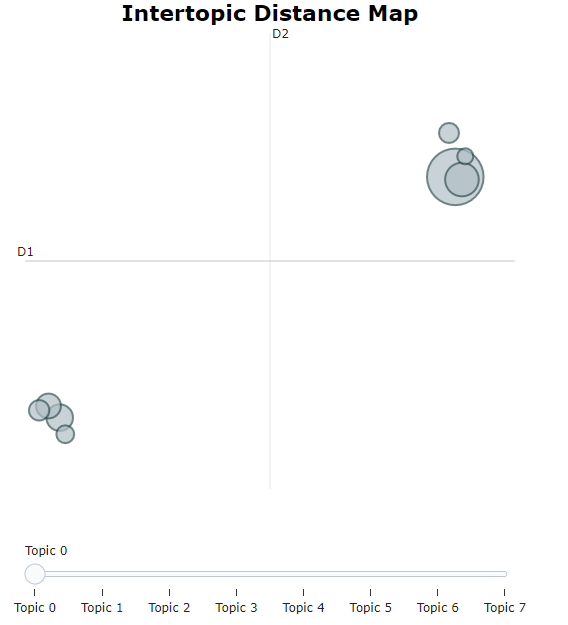

In [ ]:
display(Image('intertopicDistanceResults.PNG', width=400)) #static image of the interactive viz above

In [ ]:
topic_model.visualize_barchart()

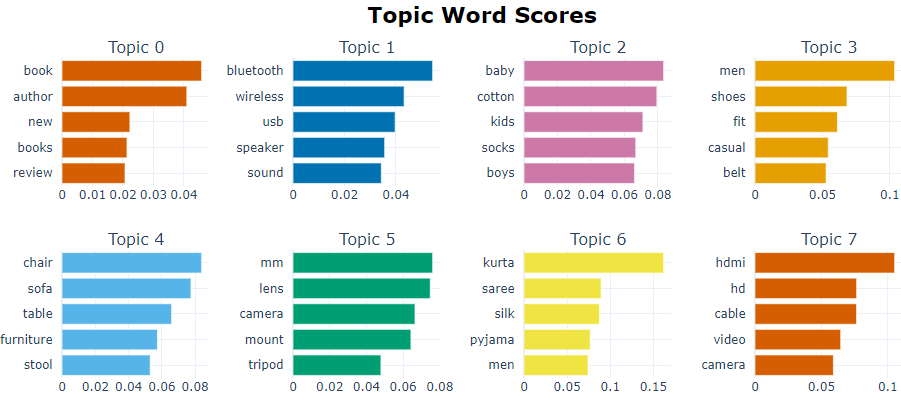

In [ ]:
display(Image('topicBarchartResults.PNG', width=800)) #static image of the interactive viz above

##### Evaluation

In [ ]:
documents = pd.DataFrame({"Document": texts,
                          "ID": range(len(texts)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluation
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [ ]:
print(coherence)


0.8276301335092245


In [ ]:
# Reevaluate coherence with others score

In [ ]:
coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_uci')
coherence_uci = coherence_model.get_coherence()

In [ ]:
print(coherence_uci)

1.4973627615861236


In [ ]:
coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_uci')
coherence_mass = coherence_model.get_coherence()
print(coherence_mass)

-0.19755712475721515


Bertopic can generate automatic labels for each topic identified

In [ ]:
topic_model.generate_topic_labels()  #labels for each topic suggested by BERTmodel, topic -1 collects outliers

['-1_size_use_set',
 '0_book_author_new',
 '1_bluetooth_wireless_usb',
 '2_baby_cotton_kids',
 '3_men_shoes_fit',
 '4_chair_sofa_table',
 '5_mm_lens_camera',
 '6_kurta_saree_silk',
 '7_hdmi_hd_cable']

For example print representative documents that Bert would label as topic 4


In [ ]:
topic_model.get_representative_docs(4)

['italica furniture armchair table combo indoor outdoor furniture set white set chairs coffee table minimalistic classy pieces furniture crafted utmost care home living room lawn backyard garden balcony terrace porch patio beautiful furniture set want polypropylene based piece furniture italica stacked kind incredibly functional stylish great choice use office home living room garden hospitals hotels restaurants outdoors chairs extremely light maintained easily online right coffee centre table seamlessly blends kind room setting simple classic geometry practical design rectangular table perfect choice living room indoor outdoor living room balcony office luxury table sleek look elegant design easily complements variety sofa sets create cosy corner porch couple garden chairs centre table living room furniture set specially curated keeping mind need chic designs intelligent space saving functionality sincerely hope enjoy',
 'mbtc seater airport visitor waiting chair set frame material mi

In [ ]:
#useful Bertopic function: find topics associated to a word

In [ ]:
topic_model.find_topics("jeans") #find most likely topics for word jeans

([3, 2, -1, 6, 4],
 [0.719367826386329,
  0.6059039692771455,
  0.5347424623454858,
  0.5292364905242908,
  0.4308704967943735])